In [11]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())

In [12]:
import utils
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

In [15]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [ ]:
# Adding JPEG artifacts
x_train, x_train_noisy = utils.cifar10_jpeg(x_train)
x_test, x_test_noisy = utils.cifar10_jpeg(x_test)
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

In [ ]:
# Displaying noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
from keras.callbacks import TensorBoard
import sys

sys.stdout = open('cdA_jpeg_output.txt', 'w')
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=False)])
sys.stdout = sys.__stdout__

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display distorted
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [1]:
################## Testing the model ##################

In [19]:
import utils
import numpy as np
import matplotlib.pyplot as plt

import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())
from keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [20]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [21]:
x_test_noisy = utils.add_jpeg(x_test, 50)

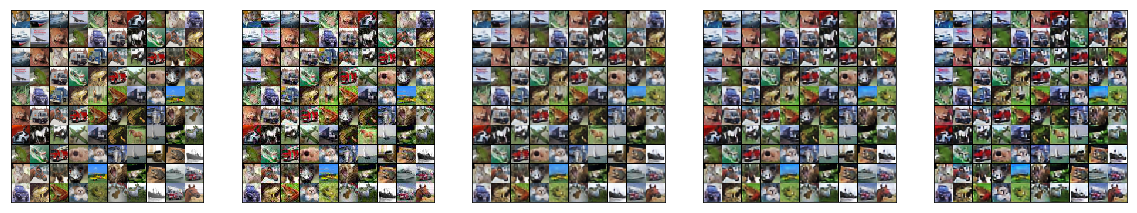

In [23]:
from keras.models import load_model
autoencoder = load_model('my_models/cdA_jpeg.h5')
ae_deblur = load_model('my_models/cdA_gblur.h5')

decoded_imgs = autoencoder.predict(x_test_noisy)
deblur_imgs1 = ae_deblur.predict(decoded_imgs)
deblur_imgs2 = ae_deblur.predict(deblur_imgs1)

x_test_vis = utils.visualize(x_test, (32, 32), (1, 1), (10, 10), 1)
x_test_noisy_vis = utils.visualize(x_test_noisy, (32, 32), (1, 1), (10, 10), 1)
decoded_vis = utils.visualize(decoded_imgs, (32, 32), (1, 1), (10, 10), 1)
deblur_imgs1_vis = utils.visualize(deblur_imgs1, (32, 32), (1, 1), (10, 10), 1)
deblur_imgs2_vis = utils.visualize(deblur_imgs2, (32, 32), (1, 1), (10, 10), 1)

n = 5
plt.figure(figsize=(20, 4))
# display original
ax = plt.subplot(1, n, 1)
plt.imshow(x_test_vis)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
# display distorted
ax = plt.subplot(1, n, 2)
plt.imshow(x_test_noisy_vis)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)    
# display reconstruction
ax = plt.subplot(1, n, 3)
plt.imshow(decoded_vis)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# deblured images 1
ax = plt.subplot(1, n, 4)
plt.imshow(deblur_imgs1_vis)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# deblured images 2
ax = plt.subplot(1, n, 5)
plt.imshow(deblur_imgs2_vis)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
################## Model Flow Diagram ####################
from keras.utils import plot_model
plot_model(autoencoder, to_file='my_models/cdA_jpeg_model.png')

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [26]:
################# Visualize weights ##################
W = autoencoder.layers[0].get_weights
#W = np.squeeze(W)
W.shape

AttributeError: 'function' object has no attribute 'shape'

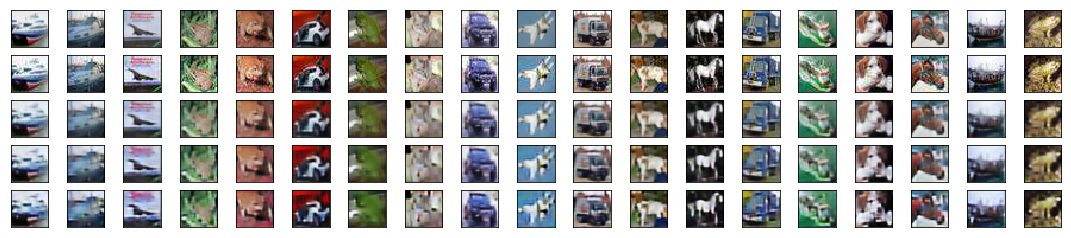

In [3]:
from keras.models import load_model
autoencoder = load_model('my_models/cdA_jpeg.h5')
ae_deblur = load_model('my_models/cdA_gblur.h5')

decoded_imgs = autoencoder.predict(x_test_noisy)
deblur_imgs1 = ae_deblur.predict(decoded_imgs)
deblur_imgs2 = ae_deblur.predict(deblur_imgs1)
no_vis = 5
n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n):
# display original
    ax = plt.subplot(no_vis, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display distorted
    ax = plt.subplot(no_vis, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display reconstruction
    ax = plt.subplot(no_vis, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# deblured images 1
    ax = plt.subplot(no_vis, n, i + 3*n)
    plt.imshow(deblur_imgs1[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# deblured images 2
    ax = plt.subplot(no_vis, n, i + 4*n)
    plt.imshow(deblur_imgs2[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()